In [1]:
import numpy as np # linear algebra
import json
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
import cv2

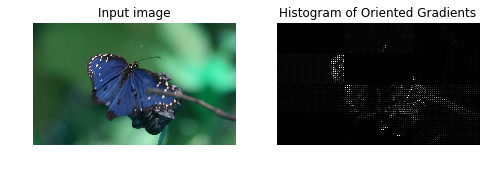

In [3]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = cv2.imread('original.jpeg?1532741436.jpeg')

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), block_norm= 'L2', visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


In [4]:
image_train = cv2.imread('original.jpeg?1532741436.jpeg')
image_train = cv2.resize(image_train, (400, 400))


fd_train, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), block_norm= 'L2', visualize=True, multichannel=True)

image_test = cv2.resize(cv2.imread('71a8491a-993c-4338-b9c6-8a089673feef_image.jpg'), (300, 300))

fd_test, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), block_norm= 'L2', visualize=True, multichannel=True)

In [6]:
clf = svm.SVC()
hog_features = np.array([fd_train, fd_test])
labels = np.array([(300, 91, 99, 368), (278, 129, 169, 246)])
#data_frame = np.hstack((hog_features, [[300, 91, 99, 368], [278, 129, 169, 246]]))
#np.random.shuffle(data_frame)

In [7]:
#What percentage of data you want to keep for training
percentage = 50
partition = int(len(hog_features)*percentage/100)


In [8]:
x_train, x_test = data_frame[:,:],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:,:].ravel() , data_frame[partition:,-1:].ravel()

print(x_train.shape)

clf.fit(hog_features,np.array([0, 1]))


NameError: name 'data_frame' is not defined

In [39]:
import argparse as ap
import os

import cv2
import matplotlib.pyplot as plt
import scipy.misc
from skimage.feature import hog
from sklearn.externals import joblib

from utils import sliding_window, pyramid, non_max_suppression, rgb2gray


class Detector:
    def __init__(self, downscale=1.5, window_size=(178, 218), window_step_size=32, threshold=0.4):
        self.clf = joblib.load(MODEL_PATH)
        self.downscale = downscale
        self.window_size = window_size
        self.window_step_size = window_step_size
        self.threshold = threshold

    def detect(self, image):
        clone = image.copy()

        image = rgb2gray(image)

        # list to store the detections
        detections = []
        # current scale of the image
        downscale_power = 0

        # downscale the image and iterate
        for im_scaled in pyramid(image, downscale=self.downscale, min_size=self.window_size):
            # if the width or height of the scaled image is less than
            # the width or height of the window, then end the iterations
            if im_scaled.shape[0] < self.window_size[1] or im_scaled.shape[1] < self.window_size[0]:
                break
            for (x, y, im_window) in sliding_window(im_scaled, self.window_step_size,
                                                    self.window_size):
                if im_window.shape[0] != self.window_size[1] or im_window.shape[1] != self.window_size[0]:
                    continue

                # calculate the HOG features
                feature_vector = hog(im_window)
                X = np.array([feature_vector])
                prediction = self.clf.predict(X)
                if prediction == 1:
                    x1 = int(x * (self.downscale ** downscale_power))
                    y1 = int(y * (self.downscale ** downscale_power))
                    detections.append((x1, y1,
                                       x1 + int(self.window_size[0] * (
                                               self.downscale ** downscale_power)),
                                       y1 + int(self.window_size[1] * (
                                               self.downscale ** downscale_power))))

            # Move the the next scale
            downscale_power += 1

        # Display the results before performing NMS
        clone_before_nms = clone.copy()
        for (x1, y1, x2, y2) in detections:
            # Draw the detections
            cv2.rectangle(clone_before_nms, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)

        # Perform Non Maxima Suppression
        detections = non_max_suppression(np.array(detections), self.threshold)

        clone_after_nms = clone
        # Display the results after performing NMS
        for (x1, y1, x2, y2) in detections:
            # Draw the detections
            cv2.rectangle(clone_after_nms, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)

        return clone_before_nms, clone_after_nms


ModuleNotFoundError: No module named 'utils'